<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Loss minimization</h1>

## 1. Aims
<div class="alert alert-info">
To perform a least squares fit to the Olympic 100m data.
</div>

## 2. Olympic data 
<div class="alert alert-info">
Download the olympic matlab file from the ASI collaborative space. Use the `loadmat()` function from scipy to load the data, then using 'male100' as key retrieve the data from the first column and the labels from the second with the proper indexing.
</div>

In [1]:
import math
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import mean_squared_error
mat = scipy.io.loadmat('olympics.mat')

In [2]:
x = mat['male100'][:,0]
t = mat['male100'][:,1]

In [3]:
print(x.shape)
print(t.shape)

(27,)
(27,)


<div class="alert alert-success">
Plot the data.
</div>

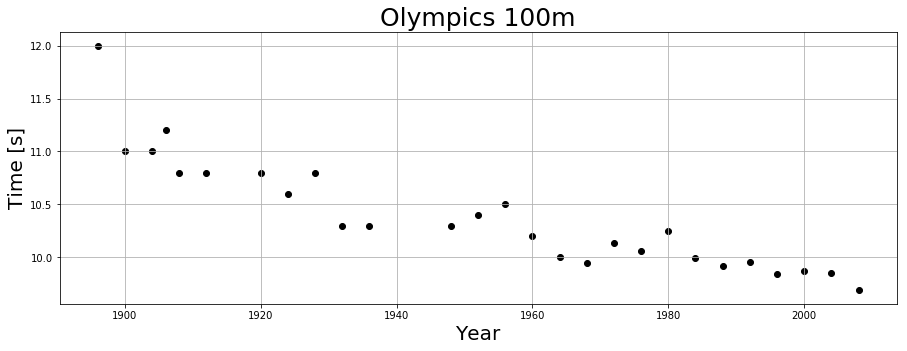

In [4]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='k')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m', fontsize=25)
plt.grid()
plt.show()

<div class="alert alert-info">
We’ll now fit the model $t = w_0 + w_1x$ to our data. This model fitting step is something we
might wish to do more than once, so it makes sense to create a function, `lsfit()`.

Recall from the lectures that

$$
w_1 = \dfrac {\bar {tx} - \bar t \bar x}{\bar {x^2} - \bar {x}^2}
$$

$$
w_0 = \bar t - w_1 \bar x
$$

where 
$$
\bar f(x) = \dfrac {1}{N} \sum_{n=1}^{N} f_n(x)
$$

Complete the function provided below accordingly.
</div>

In [5]:
def lsfit(x,t):
    """
    Least-Squares fit: 
    given data and labels, it returns W and the loss (MSE)
    """
    x, t = np.array(x), np.array(t)
    
    w1 = (np.mean(x * t) - np.mean(x) * np.mean(t)) / (np.mean(np.square(x)) - (pow(np.mean(x), 2)))
    w0 = np.mean(t) - w1 * np.mean(x)
    regr_func = np.vectorize(lambda x: w1*x + w0)
    loss = ((t - regr_func(x)) ** 2).mean(axis=0)
    return w0, w1, loss

In [6]:
w0, w1, loss = lsfit(x, t)

<div class="alert alert-info">
Inspect the values in the variables `w0` and `w1` – do they agree with the values provided in the notes?
</div>

In [7]:
print("w0:", w0)
print("w1:", w1)
print("loss:", loss)

w0: 36.4164559025
w1: -0.013330885711
loss: 0.0503071104757


<div class="alert alert-info">
We can now plot the line on top of our data. The plotted line should run through the data as shown in the lectures.
</div>

In [8]:
def get_lin_regr(x, w):
    
    regr_func = np.vectorize(lambda x: w[1]*x + w[0])
    t_pred = regr_func(x)
    return t_pred

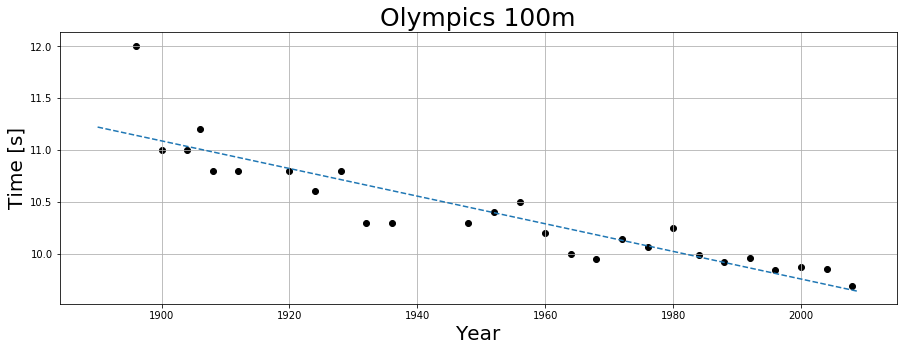

In [9]:
# Plot results
plt.figure(figsize=(15,5))

ax = plt.gca()

# computing the line in the range of years and plot the line
x_range = np.arange(1890, 2010, 1)
y = get_lin_regr(x_range, [w0, w1])
ax.plot(x_range, y, linestyle="dashed")

# scatter plot
ax.scatter(x, t, color='k')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m', fontsize=25)
plt.grid()
plt.show()

<div class="alert alert-info">
Extend your script in the following ways:
<ul>
<li>Add comments so that others (and you) can see what you’ve done.
<li>Put labels on the plot axes – xlabel and ylabel will be useful.
<li>Compute the average loss: $L = \dfrac{1}{N} \sum_{n=1}^{N} (t_n - w_0 - w_1x_n )^2 $. Do this in the lsfit function
and return it as an additional variable.
<li>Fit a function to the women’s 100m instead. This data is inside the same matlab file (use 'female100' as key).
<li>Fit a function to the men’s and women’s 100m and find the year that the two races are
predicted to have the same winning time.
</ul>
</div>

In [10]:
x_fem = mat['female100'][:,0]
t_fem = mat['female100'][:,1]
w0_fem, w1_fem, loss = lsfit(x_fem, t_fem)

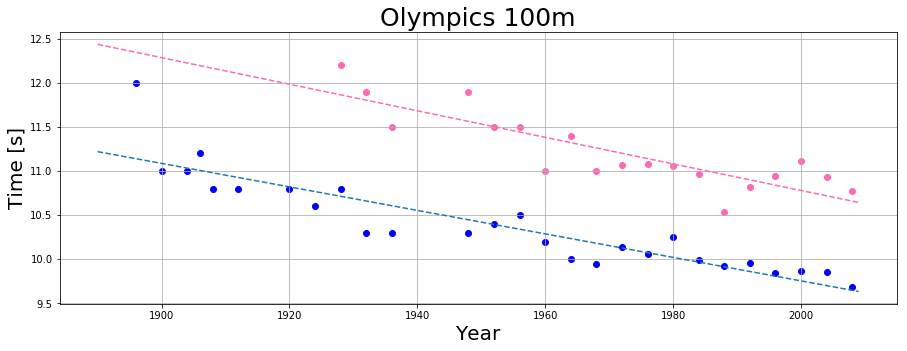

In [11]:
# Plot results for 'male' and 'female' data on same figure
plt.figure(figsize=(15,5))

ax = plt.gca()

# computing the line in the range of years and plot the line
x_range = np.arange(1890, 2010, 1)
y_men = get_lin_regr(x_range, [w0, w1])
y_women = get_lin_regr(x_range, [w0_fem, w1_fem])
ax.plot(x_range, y_men, linestyle="dashed")
ax.plot(x_range, y_women, linestyle="dashed", color="hotpink")

# men scatter plot
ax.scatter(x, t, color='b')

# women scatter plot
ax.scatter(x_fem, t_fem, color='hotpink')
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Time [s]', fontsize=20)
plt.title('Olympics 100m', fontsize=25)
plt.grid()
plt.show()

In [12]:
# Calculate year in which both races will have the same winning time
year_intersection = math.ceil((w0_fem - w0) / (w1 - w1_fem))
print("Intersection year:", year_intersection)

Intersection year: 2590


<h1 style="text-align:center">Loss minimization in vector form</h1>

## 1. Aims:
<div class="alert alert-info">
<ul>
<li> To become familiar with vector and matrix operations in python.
<li> Implementing a cross-validation procedure for model selection.
</ul>
</div>

## 2. Vectors and matrices
<div class="alert alert-info">
Load the olympics data, as in the previous lab, for `male100`.
</div>

## 2.1. Least squares in matrix form
<div class="alert alert-info">
In the lectures, we derived the following expression for the least squares solution in vector form:

$$
\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}
$$
where
$$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   1 & x_1^1 & \dots & x_1^K\\
   1 & x_2^1 & \dots & x_2^K\\
   \vdots &    \vdots & &   \vdots \\
   1 & x_N^1 & \dots & x_N^K\\
  \end{array} } \right]
$$
Our first step is to create X. This can be done in many ways. One of them is using a double list comprehension (one index for the row and one for the column), while another one is using the numpy `column_stack()` function. When dealing with matrices, `numpy.matrix` is a good data type to work with. In any case, inspect X to make sure it looks OK. To fit higher order polynomials, we need to add extra columns to X, therefore build it with $K$ as a parameter.
</div>

<div class="alert alert-info">
Given X, we can easily compute $\hat{\mathbf{w}}$ using `*`, `.I` and `.T` operators to respectively multiply, invert and transpose matrices. Make sure to correctly multiply vectors, i.e., $\mathbf{t}$, and matrices.
</div>

<div class="alert alert-info">
Write a function that computes $\hat{\mathbf{w}}$ for a given $\mathbf{X}$, $\mathbf{t}$ and $K$.
It could be useful to also define a function to create $X$ given an $x$ and a $K$.
</div>

In [17]:
def get_X(x, n):
    
    """
    Compute the matrix 'X' featuring 'x' raised to higher powers.
    Rescaling of the original inputs is recommended in order to avoid numerical instability.
    
    TO COMPLETE
    """
    if n > 3:
        x = x- np.min(x)
        x = x / 4
    
    X_ = np.ones((len(x), 1))
    for i in range(1, n + 1):
        X_ = np.column_stack((X_, np.power(x, i)))
    
    return X_

In [18]:
def get_w_hat(x_, y, n):
    
    """
    TO COMPLETE
    """
    X_ = get_X(x_, n)
    w_hat = (np.linalg.inv(X_.T.dot(X_))).dot(X_.T).dot(np.array(y))
    
    return w_hat

<div class="alert alert-info">
Try different values of K and comment the results.
<br><br>
If you want to look at the effect of increasing the polynomial order above 4, you’ll need to
rescale the $x$ (Olympic year) values (do this before you calculate all the $x^k$ stuff)(remember that you need to do the same thing to any test years too...).
</div>

In [19]:
def lsfit_k(x, t, k):
    
    # Compute optimal 'w' and 'loss' for a model of polynomial order 'k'

    """
    TO COMPLETE
    """

    # W HAT
    w_hat = get_w_hat(x, t, k)
    
    # LOSS
    loss = np.square(t - get_X(x, k).dot(w_hat)).mean(axis=0)
    
    return w_hat, loss

In [20]:
K = 8
for k in range(K):
    
    (w_hat, loss) = lsfit_k(x, t, k)
    """
    Plot results for different 'k' (separate plots)
    In each case, also indicate the loss obtained by the constructed model
    """
    print(k, w_hat, loss)
    
plt.show()

0 [ 10.38962963] 0.268092455418
1 [  3.64164559e+01  -1.33308857e-02] 0.0503071104757
2 [  4.55597855e+02  -4.43160485e-01   1.10151552e-04] 0.0379585466347
3 [  2.36798576e+04  -3.61403888e+01   1.83965118e-02  -3.12191035e-06] 0.0296116568245
4 [  1.16350040e+01  -2.86490307e-01   2.55519109e-02  -1.06246320e-03
   1.53982916e-05] 0.027060311455
5 [  1.17609670e+01  -4.53086023e-01   6.99555283e-02  -5.37006803e-03
   1.88766668e-04  -2.46275398e-06] 0.023495510356
6 [  1.18214350e+01  -5.83023559e-01   1.23237491e-01  -1.35198144e-02
   7.54677756e-04  -2.05945007e-05   2.17866377e-07] 0.0220163868218
7 [  1.18843138e+01  -8.25429781e-01   2.65129341e-01  -4.40342127e-02
   3.85909024e-03  -1.82498533e-04   4.40637887e-06  -4.26041536e-08] 0.0197026327914


<div class="alert alert-info">
Comment on your results.
</div>

<div class="alert alert-info">
To make predictions, at a column vector of test points, `x_test`, we need to create `X_test` and then multply it by `w_hat`. For example:</div>

In [ ]:
k_pred = 3
x_test = [2012, 2016]

X_test = ... # TO COMPLETE
w_hat = ... # TO COMPLETE

predictions = ... # TO COMPLETE

print("Predicted time in 2012:", predictions[0])
print("Predicted time in 2016:", predictions[1])

<div class="alert alert-info">
Write a function that, when given `x`, `t` and `x_test`, computes `w_hat` and makes predictions at `x_test`.</div>

In [ ]:
def predict(x, t, x_test, K=1):
       
    """
    TO COMPLETE
    """
    
    return predictions

In [ ]:
print(predict(x, t, x_test, 1))

<div class="alert alert-info">You may find it interesting to test your code with different datasets. The following code will generate data from a third order polynomial:</div>

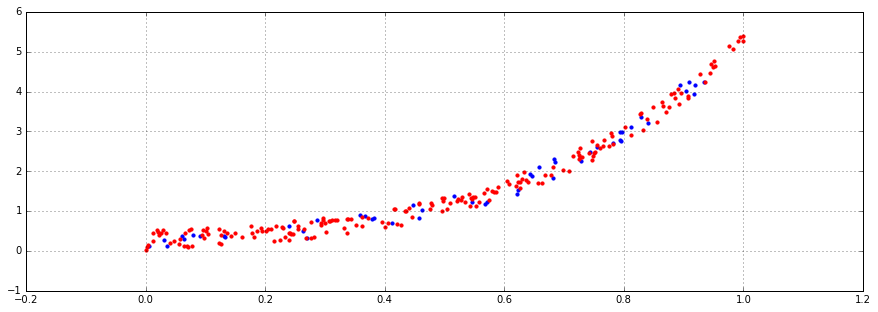

In [5]:
x_ex = np.sort(np.random.rand(50))
x_test_ex = np.sort(np.random.rand(200))
noise = 0.5
t_ex = 5*(x_ex**3) - x_ex**2 + x_ex + np.random.rand(50)*noise # third order plus noise
t_test_ex = 5*(x_test_ex**3) - x_test_ex**2 + x_test_ex + np.random.rand(200)*noise;
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x_ex, t_ex, color='b', s=10)
ax.scatter(x_test_ex, t_test_ex, color='r', s=10)
plt.grid()
plt.show()

In [ ]:
K_ex = 7
mean_err_ex = []

"""
Evaluate how the mean error changes with respect to higher order polynomial models.
"""

for k in range(1, K_ex):
    predictions_ex = ... # TO COMPLETE
    mean_err_ex.append(...) # TO COMPLETE

<div class="alert alert-info">
For which polynomial order is the smallest error observed?
</div>

In [ ]:
plt.figure(figsize=(15,5))
x_ax = range(1,K_ex)
plt.plot(x_ax,mean_err_ex)
plt.grid()
plt.show()

## 3. Cross-validation

### Write a script that will perform LOO cross-validation
<div class="alert alert-info">
Some hints (you can generate data using the code above – you won’t need to define `x_test` or `t_test`)
<br>
You’ll need to:
<ul>
<li> Write a loop that removes the data-points one by one, find w_hat on the
reduced dataset and then compare the prediction on the removed data-point and compare
it to the true value.

<li> Create a copy of `X` with the n-th data-point (row) removed

<li> Create a copy of the n-th row of `X`

</ul>
You can use your previous function for finding `w` hat and pass it `trainX` instead of `X`.
<br>
Plot the average error for different polynomial orders. 
<br><br>
Does your code predict the correct one?
</div>

<div class="alert alert-success">
Let's generate the dataset from scratch.
</div>

In [ ]:
x_ex = np.sort(np.random.rand(50))
noise = 0.5
t_ex = 5*(x_ex**3) - x_ex**2 + x_ex + np.random.rand(50)*noise # third order plus noise

In [ ]:
def LOOCV(data, labels, order):
    
    """
    TO COMPLETE
    """
    
    return mse_list

In [ ]:
mse_LOOCV = LOOCV(x_ex, t_ex, 8)

for i in range(mse_LOOCV.size):
    print("Order:", i, "MSE:", mse_LOOCV[i])

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(mse_LOOCV)
plt.xlabel("Order")
plt.ylabel("MSE")
plt.grid()
plt.show()

<h1 style="text-align:center">Bayesian Linear Regression</h1>


## 1. Aims
<div class="alert alert-info">
<ul>
<li>Implement the maximum likelihood estimate.
<li>Use this to explore uncertainty in parameter values.
<li>Make predictions.
</ul>
</div>

## 2. LOO CV
<div class="alert alert-info">
Make sure you’ve completed the previous assignments.
</div>

## 3. Maximum likelihood
<div class="alert alert-info">
1. Using the ML estimators given in the lectures, compute $\hat{\mathbf{w}}$ and $\hat{\sigma^2}$ on the Olympic data for polynomials of first, second and third order. 
<br>
2. Plot polynomial order versus $\hat{\sigma^2}$. What do you expect to see? What do you see?
</div>


In [ ]:
def get_sigma2_hat(X, w_hat, t):
    
    """
    TO COMPLETE
    """
    
    return sigma2_hat

<div class="alert alert-info">
3. Using your CV code from the previous exercise, perform a LOO CV analysis for maximum likelihood for polynomials of order 0 to 8.</div>

## 4. Uncertainty in estimates
<div class="alert alert-info">
1. For the first order polynomial, compute $cov(\hat{\mathbf{w}})$ (use $\hat{\sigma^2}$ in place of $\sigma^2$).
<br><br>
$$
cov(\hat{\mathbf{w}}) = \sigma^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$
</div>


In [ ]:
def get_cov_w(x, t, order):
    
    """
    TO COMPLETE
    """
    
    return cov_w_hat 

<div class="alert alert-info">
2. Sample 10 values of $\hat{\mathbf{w}}$ from $\mathcal{N}(\hat{\mathbf{w}}, cov(\hat{\mathbf{w}}))$ using `multivariate_normal()` from the numpy random module and plot all the models with the data.
</div>


In [ ]:
w_samples = []
t_pred = []
plt.figure(figsize=(15,8))
plt.subplot(111)

for i in range(10):
    w_samples.append(np.matrix(np.random.multivariate_normal( ... )).T) # TO COMPLETE
    t_pred.append( ... ) # TO COMPLETE
    plt.plot(x, t_pred[i])
    
plt.scatter(x, t, color='k')    
plt.xlabel('Year', fontsize=15)
plt.ylabel('Time [s]', fontsize=15)
plt.title('Olympics 100m', fontsize=20)
plt.grid()
plt.show()

## 5. Uncertainty in predictions
<div class="alert alert-info">
1. Load synthetic_data.mat from the ASI collaborative space. It includes the
variables:
<ul>
<li>x
<li>t
<li>testx
</ul>
2. Pick a polynomial order between 1 and 7 (repeat with others if you have time).
<br>
3. Find $cov(\hat{\mathbf{w}})$ and $\hat{\sigma^2}$.
</div>


In [ ]:
synth = scipy.io.loadmat('synthetic_data.mat')
x = synth['x'].reshape(-1)
t = synth['t'].reshape(-1)
x_test = synth['testx'].reshape(-1)
print(x.shape)
print(t.shape)
print(x_test.shape)

In [ ]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='k')
plt.title('Synthetic Data', fontsize=25)
plt.grid()
plt.show()

<div class="alert alert-info">
4. Compute the predictive means. If you create $\mathbf{X}_{new}$ in exactly the same way as you created X, you’ll be able to do this for all test points in one operation:
$$
t_{new} = \mathbf{X}_{new} \mathbf{\hat{\mathbf{w}}}
$$
</div>


In [ ]:
X_test = ... # TO COMPLETE
t_test = ... # TO COMPLETE

<div class="alert alert-info">
5. For each $\mathbf{x_{new}}$ (each value of `testx` expanded into a vector, i.e., each row of $\mathbf{X}_{new}$), compute the predictive variance:
$$
\sigma^2_{new} = \sigma^2 \mathbf{x^T_{new}}(\mathbf{X^TX})^{-1} \mathbf{x_{new}}
$$
</div>

<div class="alert alert-info">
6. Use `errorbar()` to plot the data.
</div>

In [ ]:
plt.figure(figsize=(15,10))
plt.errorbar( ... ) # TO COMPLETE
plt.scatter( ... ) # TO COMPLETE
plt.title('Synthetic Data', fontsize=20)
plt.grid()
plt.show()

<div class="alert alert-info">
7. What do you notice – is it what you expected?
</div>

<div class="alert alert-info">
8. Repeat with the data given in the file synthetic_data_2.mat. What do you notice?
</div>

In [ ]:
synth = scipy.io.loadmat('synthetic_data_2.mat')
x = synth['x'].reshape(-1)
t = synth['t'].reshape(-1)
x_test = synth['testx'].reshape(-1)
# print(x.shape)
# print(t.shape)
# print(x_test.shape)
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(x, t, color='k')
plt.title('Synthetic Data', fontsize=25)
plt.grid()
plt.show()

<h1 style="text-align:center">Bayesian inference for a coin tossing experiment</h1>


## 1. Aims:
<div class="alert alert-info">
<ul>
<li> To become familiar with statistical operations in python.
<li> To do some simple Bayesian things.
</ul>
</div>

## 2. Coin Tossing
### 2.1 Computing posterior
<div class="alert alert-info">
The beta probability density function is defined as:
$$
p(r \vert \alpha, \beta) = \dfrac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}r^{\alpha-1}(1-r)^{\beta-1} 
$$
where $0 \le r \le 1$ and $\alpha, \beta> 0$.
You can use the `plot_beta()` function.
</div>

In [ ]:
from scipy.stats import beta
from scipy.special import gamma as gamma_func
from scipy.misc import comb

In [ ]:
def plot_beta(a,b, plot=False):
    plt.figure(figsize=(15,5))
    x = np.linspace(0, 1, 1000)
    plt.plot(x, beta.pdf(x, a, b),'r')
    plt.title("beta pdf: alpha=" + str(a) + " beta=" + str(b))
    plt.show()

In [ ]:
plot_beta(a=2, b=2)

<div class="alert alert-info">
1. $r$ is the probability of some hypothetical coin landing heads. The beta distribution is a suitable prior distribution for $r$. Choose 2 different pairs of values $\alpha$ and $\beta$ and plot the corresponding densities. For both cases, describe the possible beliefs they encode about the coin. Note, there is no ‘right’ answer here, just think about how likely different values of $r$ are in your densities and how this reflects on the coin.
</div>

In [ ]:
plot_beta(a=1, b=1)

<div class="alert alert-info">
Observe how the distribution changes for different values of 'a' and 'b', and comment on your results.
</div>

In [ ]:
plot_beta( ... ) # TO COMPLETE

<div class="alert alert-info">
2. `coin1()` and `coin2()` are two ‘coins’ that you can use. In either case, calling the function with an argument N tosses the coin N times and returns the number of heads. Pick either one and using the equations we derived in the class, along with any choice for $\alpha$ and $\beta$, plot the posterior density for $r$ after $N = 1, 5, 10, 100$ tosses. Use `plot_beta()` to do the plotting. You can put them all on one plot or all on separate plots. Explain what you see.
</div>

In [ ]:
def coin1(N):
    return sum(np.random.random(N)<=0.3)
def coin2(N):
    return sum(np.random.random(N)<=0.8)

In [ ]:
yN = [coin2(N) for N in range(1000)]
plt.figure(figsize=(10,5))
plt.plot(list(range(1000)), yN)
plt.xlabel("Number of tosses")
plt.ylabel("Number of heads")
plt.title("coin2")
plt.grid()
plt.show()

<div class="alert alert-success">
So, `coin2()` is biased to generate more heads (roughly 8 out of 10).
</div>

In [ ]:
N = 1000

yN1, yN2 = coin1(N), coin2(N)

# Assume coins are fair

alpha1 = 50
beta1 = 50

# Compute the posterior 'gamma' and 'delta' parameters
gamma1, gamma2 = ... # TO COMPLETE
delta1, delta2 = ... # TO COMPLETE

plt.figure(figsize=(15,5))
x = np.linspace(0, 1, 1000)
plt.plot(x, beta.pdf(x, alpha1, beta1),'r', label='prior')
plt.plot(x, beta.pdf(x, gamma1, delta1),'b', label='posterior coin1')
plt.plot(x, beta.pdf(x, gamma2, delta2),'g', label='posterior coin2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
N = 1000

yN1, yN2 = coin1(N), coin2(N)

# Assume coins are biased

alpha1 = 50
beta1 = 10

# Compute the posterior 'gamma' and 'delta' parameters

gamma1, gamma2 = ... # TO COMPLETE
delta1, delta2 = ... # TO COMPLETE


plt.figure(figsize=(15,5))
x = np.linspace(0, 1, 1000)
plt.plot(x, beta.pdf(x, alpha1, beta1),'r', label='prior')
plt.plot(x, beta.pdf(x, gamma1, delta1),'b', label='posterior coin1')
plt.plot(x, beta.pdf(x, gamma2, delta2),'g', label='posterior coin2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
N = [1, 5, 10, 100, 1000]
cs = ['b', 'c', 'g', 'y', 'r']
a = 2
b = 2
x = np.linspace(0, 1, 100)
plt.figure(figsize=(15,8))
for i,n in enumerate(N):
    # Compute the posterior distribution for coin2 given 'n' tosses 
    yN1 = ... # TO COMPLETE
    gamma = ... # TO COMPLETE
    delta = ... # TO COMPLETE
    plt.plot(x, beta.pdf( ... ),color=cs[i], label="N="+str(n)) # TO COMPLETE
    
plt.plot(x, beta.pdf( ... ),'k+', label='prior') # TO COMPLETE
plt.title("Coin2")
plt.legend()
plt.grid()
plt.show()

<div class="alert alert-info">
3. Repeat the previous exercise with a different set of prior parameter values ($\alpha$ and $\beta$). What
do you notice?
</div>

In [ ]:
N = [1, 5, 10, 100, 1000]
cs = ['b', 'c', 'g', 'y', 'r']
a = 1
b = 5

"""
TO COMPLETE
"""

### 2.2 Making predictions
<div class="alert alert-info">
`fairground()` is a coin game – you pay £1 to play. The stall owner tosses a coin ten times. If there are 6 or fewer heads, you win £2. The function returns 1 if you win and 0 if you lose.
<br><br>
4. The probability that you win could be approximated by playing the game lots of times and computing the proportion of times you do win! By embedding fairground.m in a loop, approximate the probability that you will win in this way.
</div>

In [ ]:
def fairground():
    return sum(np.random.random(10)<0.8) <= 6 # coin2

In [ ]:
print("Approx Winning Probability:", sum([fairground() for i in range(10000)])/10000)

<div class="alert alert-info">
5. In the lectures, we derived an expression for the probability of getting $y_{new}$ heads in N tosses having observed $y_N$ heads in N tosses by taking an expectation with respect to the posterior.
Choose $\alpha$ and $\beta$ as you please (as long as you can justify your choice – do you know anything about this coin?). Use `coin2()` to generate $y_N$ for $N = 10$. Compute the posterior parameters. By using them, the expression from the lectures and the following identity, compute the probability that you will win given the coin tosses you have observed (i.e., you just need to add together a series of the expressions you derived in the lecture). 

Note that this quantity depends on the prior and the particular $y_N$ you get from `coin2()` and therefore could be quite different from the quantity computed in the previous question.
$$
P(y_{new}\le 6 \vert y_N, \alpha, \beta) = \sum_{a=0}^{6} P(y_{new}=a \vert y_N, \alpha, \beta)
$$
</div>

In [ ]:
Nlook = 50 # the higher this number, the lower our winning probability
yN = coin2(Nlook)

# Assume the coin is unbiased

alpha1 = ... # TO COMPLETE
beta1 = ... # TO COMPLETE
gamma1 = ... # TO COMPLETE
delta1 = ... # TO COMPLETE

N = 10
p_ynew_se_six = 0 # smaller or equal to 6

for ynew in range(7):
    # Compute probability using formula given in slides
    
    """
    TO COMPLETE
    """

print(p_ynew_se_six)

In [ ]:
Nlook = 50 # the higher this number, the lower the more accurate our winning probability
yN = coin2(Nlook)

# Assume the coin is biased

alpha1 = ... # TO COMPLETE
beta1 = ... # TO COMPLETE
gamma1 = ... # TO COMPLETE
delta1 = ... # TO COMPLETE

N = 10;
p_ynew_se_six = 0 # smaller or equal to 6

for ynew in range(7):
    # Compute probability using formula given in slides
    
    """
    TO COMPLETE
    """

print(p_ynew_se_six)